In [58]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from gerrychain import Graph, Partition

import pandas as pd
import geopandas as gpd
import maup
import time

maup.progress.enabled = True

In [34]:
def load_data(file_name):
    start_time = time.time()
    df = gpd.read_file(file_name)
    end_time = time.time()
    print(f'The time to import {file_name} is: {(end_time - start_time) / 60} mins')

    return df

In [3]:
population_df = load_data('./or_pl2020_b/or_pl2020_b.shp')

The time to import ./or_pl2020_b/or_pl2020_b.shp is: 93.33439429998398 mins


In [4]:
election_df = load_data('./or_vest_20/or_vest_20.shp')

The time to import ./or_vest_20/or_vest_20.shp is: 0.041604546705881755 mins


In [5]:
sen_district_df = load_data('./or_sldu_2021/Senate_LC_Draft_2_-_Revised_.shp')

The time to import ./or_sldu_2021/Senate_LC_Draft_2_-_Revised_.shp is: 0.0060303012530008955 mins


In [9]:
sen_district_df.shape

(30, 15)

In [10]:
print(population_df.columns)
print(election_df.columns)
print(sen_district_df.columns)

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20',
       'NAME20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20', 'AWATER20',
       ...
       'P0050002', 'P0050003', 'P0050004', 'P0050005', 'P0050006', 'P0050007',
       'P0050008', 'P0050009', 'P0050010', 'geometry'],
      dtype='object', length=383)
Index(['STATE', 'COUNTY', 'PRECINCT', 'NAME', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20PREGHAW', 'G20PREPHUN', 'G20PREOWRI', 'G20USSDMER',
       'G20USSRPER', 'G20USSLDYE', 'G20USSGTAH', 'G20USSOWRI', 'G20ATGDROS',
       'G20ATGRCRO', 'G20ATGLHED', 'G20ATGOWRI', 'G20SOSDFAG', 'G20SOSRTHA',
       'G20SOSLMAR', 'G20SOSGPAR', 'G20SOSOWRI', 'G20TREDREA', 'G20TRERGUD',
       'G20TREIHEN', 'G20TRECMAR', 'G20TREOWRI', 'geometry'],
      dtype='object')
Index(['LONGNAME', 'SHORTNAME', 'DISTRICT', 'COLOR', 'TOTAL', 'TARGET_DEV',
       'TOTALHISP', 'WHITENH', 'BLACKNH', 'AIANNH', 'ASIANNH', 'HPINH',
       'OTHERNH', 'MLTMNNH', 'geometry'],
      dtype='object')


In [12]:
print(sen_district_df)

       LONGNAME SHORTNAME  DISTRICT       COLOR   TOTAL  TARGET_DEV  \
0    District 1        D1         1  2127829120  142212         970   
1    District 2        D2         2  1015926656  141786         544   
2    District 3        D3         3   101601152  142502        1260   
3    District 4        D4         4  1627761792  142435        1193   
4    District 5        D5         5  1675345024  140391        -851   
5    District 6        D6         6  1973951616  141318          76   
6    District 7        D7         7  -847814016  141405         163   
7    District 8        D8         8  -630203264  141755         513   
8    District 9        D9         9  -212241062  142091         849   
9   District 10       D10        10  -713176448  142303        1061   
10  District 11       D11        11  1697406336  142263        1021   
11  District 12       D12        12  -973899392  141526         284   
12  District 13       D13        13  -201293376  141227         -15   
13  Di

In [13]:
district_col_name = "DISTRICT"

In [20]:
blocks_to_precincts_assignment = maup.assign(population_df.geometry.to_crs(2913), election_df.geometry)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1331/1331 [00:18<00:00, 71.86it/s]


- Total: P0020001
- Hispanic or Latino P0020002
- White alone P0020005
- Black or African American alone P0020006
- American Indian and Alaska Native alone P0020007
- Asian alone P0020008
- Native Hawaiian and Other Pacific Islander alone P0020009
- Some Other Race alone P0020010
- Population of two or more races: P0020011

In [21]:
pop_column_names = ['P0020001', 'P0020002', 'P0020005', 'P0020006', 'P0020007',
                    'P0020008', 'P0020009', 'P0020010', 'P0020011']

In [104]:
for col in pop_column_names:
    if col.startswith('P00'):
        print(col)

P0020001
P0020002
P0020005
P0020006
P0020007
P0020008
P0020009
P0020010
P0020011


In [22]:
for name in pop_column_names:
    election_df[name] = population_df[name].groupby(blocks_to_precincts_assignment).sum()

In [100]:
print(population_df['P0020001'].sum())
print(election_df['P0020001'].sum())
print(sen_district_df['TOTAL'].sum())

4237256
4237224.0
4237256


In [103]:
print(maup.doctor(election_df))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1331/1331 [00:04<00:00, 267.12it/s]


There are 1137 overlaps.
There are 6923 holes.
There are some invalid geometries.
False


In [84]:
repaired_election_df = maup.smart_repair(election_df, snap_precision=8)

Gaps to simplify:   3%|███▍                                                                                                              | 304/10095 [02:19<1:14:53,  2.18it/s]


Snapping all geometries to a grid with precision 10^( -2 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22321/22321 [00:31<00:00, 709.92it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
1 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 10106it [47:05,  3.58it/s]                                                                                                                                   
Gaps to fill: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [01:33<00:00,  3.91it/s]

In [85]:
print(maup.doctor(repaired_election_df))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1331/1331 [00:04<00:00, 292.07it/s]


There are 1 holes.
False


In [86]:
precincts_to_districts_assignment = maup.assign(repaired_election_df.geometry, sen_district_df.geometry.to_crs(2913))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.60it/s]


In [87]:
repaired_election_df['SEN'] = precincts_to_districts_assignment

In [88]:
print(set(repaired_election_df['SEN']))
for precinct_index in range(len(repaired_election_df)):
    repaired_election_df.at[precinct_index, 'SEN'] = sen_district_df.at[repaired_election_df.at[precinct_index, 'SEN'], district_col_name]
print(set(sen_district_df[district_col_name]))
print(set(repaired_election_df['SEN']))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}


In [94]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP',
                                        'G20PREDBID': 'G20PRED', 'G20PRERTRU': 'G20PRER', 'G20USSDMER': 'G20USSD', 
                                        'G20USSRPER': 'G20USSR'}
repaired_election_df.rename(columns=rename_dict, inplace = True)

In [95]:
final_election_df = repaired_election_df

In [96]:
final_election_df

,STATE,COUNTY,PRECINCT,NAME,G20PRED,G20PRER,G20PRELJOR,G20PREGHAW,G20PREPHUN,G20PREOWRI,...,TOTPOP,HISP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,SEN
0,41,Multnomah,4506,4506,2656,717,30,32,6,24,...,5727.0,598.0,3337.0,526.0,68.0,658.0,58.0,36.0,446.0,23
1,41,Multnomah,4409,4409,1613,473,24,22,11,15,...,5103.0,1322.0,2665.0,453.0,40.0,281.0,51.0,15.0,276.0,22
2,41,Multnomah,4404,4404,8264,907,106,68,32,80,...,19470.0,3298.0,11221.0,1884.0,148.0,1086.0,234.0,88.0,1511.0,22
3,41,Multnomah,4502,4502,3948,482,49,32,9,27,...,6599.0,628.0,4775.0,230.0,33.0,430.0,23.0,53.0,427.0,23
4,41,Multnomah,4501,4501,9190,785,78,36,18,57,...,13895.0,738.0,11262.0,257.0,42.0,521.0,14.0,71.0,990.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,41,Clackamas,201,201,2656,1465,84,13,2,35,...,7232.0,767.0,5362.0,89.0,24.0,494.0,12.0,34.0,450.0,13
1327,41,Washington,435,435,2335,1608,82,18,8,49,...,6890.0,576.0,5584.0,28.0,24.0,231.0,25.0,33.0,389.0,13
1328,41,Washington,425,425,452,550,15,4,1,9,...,1499.0,108.0,1236.0,2.0,10.0,35.0,3.0,9.0,96.0,13
1329,41,Yamhill,13,Yamhill City & Rural,1091,2040,58,17,5,18,...,4568.0,322.0,3911.0,10.0,20.0,31.0,2.0,20.0,252.0,12


In [143]:
final_election_df = repaired_election_df.drop(columns=['G20PRELJOR', 'G20PREGHAW', 'G20PREPHUN', 'G20PREOWRI',
                          'G20USSLDYE', 'G20USSGTAH', 'G20USSOWRI', 'G20ATGDROS',
                          'G20ATGRCRO', 'G20ATGLHED', 'G20ATGOWRI', 'G20SOSDFAG',
                          'G20SOSRTHA', 'G20SOSLMAR', 'G20SOSGPAR', 'G20SOSOWRI',
                          'G20TREDREA', 'G20TRERGUD', 'G20TREIHEN', 'G20TRECMAR',
                          'G20TREOWRI'])
list(final_election_df.columns)

['STATE',
 'COUNTY',
 'PRECINCT',
 'NAME',
 'G20PRED',
 'G20PRER',
 'G20USSD',
 'G20USSR',
 'geometry',
 'TOTPOP',
 'HISP',
 'NH_WHITE',
 'NH_BLACK',
 'NH_AMIN',
 'NH_ASIAN',
 'NH_NHPI',
 'NH_OTHER',
 'NH_2MORE',
 'SEN']

<Axes: >

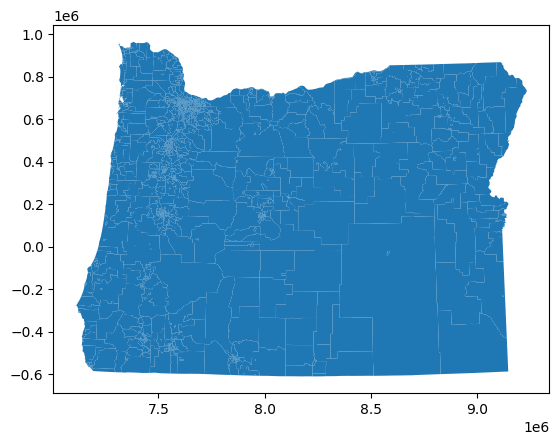

In [144]:
final_election_df.plot()

In [145]:
pop_vals = [final_election_df.loc[final_election_df['SEN'] == n, 'TOTPOP'].sum() for n in range(1, 31)]
print(pop_vals)

[141787.0, 144720.0, 143318.0, 144688.0, 142274.0, 140832.0, 135320.0, 142521.0, 142840.0, 143012.0, 142206.0, 139335.0, 131888.0, 145118.0, 138582.0, 144478.0, 127685.0, 154053.0, 140263.0, 140569.0, 139214.0, 149627.0, 139841.0, 145801.0, 135528.0, 140891.0, 133178.0, 138061.0, 141450.0, 148144.0]


In [146]:
final_election_df.to_file("./OR/OR_1.shp")
shp_file = gpd.read_file('./OR/OR_1.shp')
shp_file.to_file('./OR/OR_1.json', driver='GeoJSON')

# Working Chain

In [135]:
import MAUP as mp
from importlib import reload
reload(mp)

<module 'MAUP' from '/Users/kenny/PycharmProjects/lab-4-maup-and-data-dongKenny/MAUP.py'>

/Users/kenny/anaconda3/envs/gerry/lib/python3.11/site-packages/gerrychain/graph/graph.py:311: UserWarning: NA values found in column TOTPOP!
  warnings.warn("NA values found in column {}!".format(column))
/Users/kenny/anaconda3/envs/gerry/lib/python3.11/site-packages/gerrychain/graph/graph.py:311: UserWarning: NA values found in column HISP!
  warnings.warn("NA values found in column {}!".format(column))
/Users/kenny/anaconda3/envs/gerry/lib/python3.11/site-packages/gerrychain/graph/graph.py:311: UserWarning: NA values found in column NH_WHITE!
  warnings.warn("NA values found in column {}!".format(column))
/Users/kenny/anaconda3/envs/gerry/lib/python3.11/site-packages/gerrychain/graph/graph.py:311: UserWarning: NA values found in column NH_BLACK!
  warnings.warn("NA values found in column {}!".format(column))
/Users/kenny/anaconda3/envs/gerry/lib/python3.11/site-packages/gerrychain/graph/graph.py:311: UserWarning: NA values found in column NH_AMIN!
  warnings.warn("NA values found in 

The time of execution of above program is: 0.44633126656214395 mins


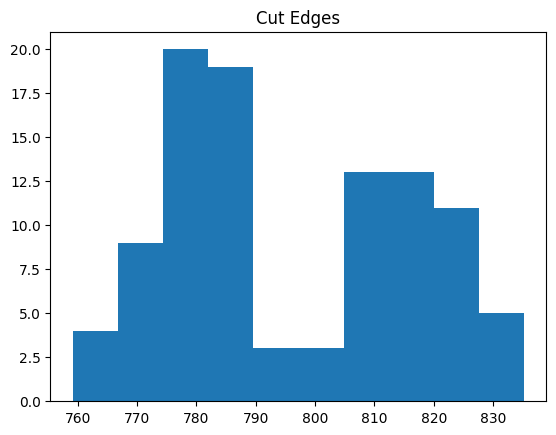

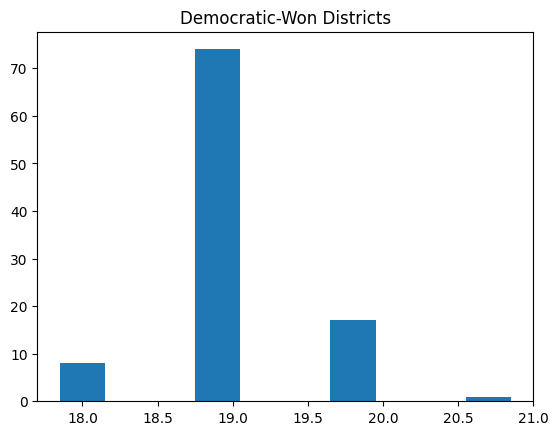

In [147]:
start_time = time.time()

or_graph = Graph.from_file('./OR/OR_1.json')

initial_partition = Partition(
    or_graph,
    assignment='SEN',
    updaters=mp.create_updaters()
)

chain = mp.create_chain(initial_partition, 0.1, total_steps_in_run=100)

cut_edge_ensemble, dem_ensemble = mp.walk(chain)

mp.create_hist(cut_edge_ensemble, 'Cut Edges')
mp.create_hist(dem_ensemble, 'Democratic-Won Districts')

end_time = time.time()
print(f"The time of execution of above program is: {(end_time - start_time) / 60} mins")